#  GPS Fraud Detection using Data Science and Machine Learning

This notebook demonstrates a complete pipeline to detect **intentional GPS blackouts or manipulations** in vehicle GPS data using Data Science and Machine Learning techniques.


In [7]:
!pip install haversine folium --quiet



In [8]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine, Unit
import folium

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [9]:
from google.colab import files
uploaded = files.upload()



Saving processed_gps_data.csv to processed_gps_data.csv


# Load and Inspect Data

In [10]:
df = pd.read_csv("/content/processed_gps_data.csv", parse_dates=['timestamp'])
df.head()

,timestamp,vehicle_id,imei,latitude,longitude,speed,ignition,gps_fixed
0,2025-02-28 17:59:57+00:00,8.6307E+14,8.630700e+14,21.183483,78.379646,0,0,1
1,2025-02-28 18:00:57+00:00,8.6307E+14,8.630700e+14,21.183483,78.379646,0,0,1
2,2025-02-28 18:01:57+00:00,8.6307E+14,8.630700e+14,21.183483,78.379646,0,0,1
3,2025-02-28 18:02:57+00:00,8.6307E+14,8.630700e+14,21.183483,78.379646,0,0,1
4,2025-02-28 18:03:57+00:00,8.6307E+14,8.630700e+14,21.183483,78.379646,0,0,1


# Data Preprocessing & Time Gap Detection

In [11]:
df = df.sort_values(by=['vehicle_id', 'timestamp'])
df['time_diff'] = df.groupby('vehicle_id')['timestamp'].diff().dt.total_seconds()

In [12]:
# Flag GPS blackout if gap > 120s
df['potential_blackout'] = df['time_diff'] > 120
df['gps_fixed'] = df['gps_fixed'].astype(int)
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df['speed'] = pd.to_numeric(df['speed'], errors='coerce')

In [13]:
df.head()

,timestamp,vehicle_id,imei,latitude,longitude,speed,ignition,gps_fixed,time_diff,potential_blackout
0,2025-02-28 17:59:57+00:00,8.6307E+14,8.630700e+14,21.183483,78.379646,0,0,1,NaN,False
1,2025-02-28 18:00:57+00:00,8.6307E+14,8.630700e+14,21.183483,78.379646,0,0,1,60.0,False
2,2025-02-28 18:01:57+00:00,8.6307E+14,8.630700e+14,21.183483,78.379646,0,0,1,60.0,False
3,2025-02-28 18:02:57+00:00,8.6307E+14,8.630700e+14,21.183483,78.379646,0,0,1,60.0,False
4,2025-02-28 18:03:57+00:00,8.6307E+14,8.630700e+14,21.183483,78.379646,0,0,1,60.0,False


# Feature Engineering – Blackout Context

In [14]:
# Build features from blackout points
features = []
for vehicle, group in df.groupby('vehicle_id'):
    group = group.reset_index(drop=True)
    for i in range(1, len(group)):
        if group.loc[i, 'potential_blackout']:
            before = group.loc[i - 1]
            after = group.loc[i]

            try:
                distance = haversine(
                    (before['latitude'], before['longitude']),
                    (after['latitude'], after['longitude']),
                    unit=Unit.KILOMETERS
                )
            except:
                distance = 0

            features.append({
                'vehicle_id': vehicle,
                'start_time': before['timestamp'],
                'end_time': after['timestamp'],
                'blackout_duration': group.loc[i, 'time_diff'],
                'distance': distance,
                'speed_before': before['speed'],
                'speed_after': after['speed'],
                'ignition_status': after['ignition']
            })

In [15]:
feature_df = pd.DataFrame(features)
feature_df.head()

,vehicle_id,start_time,end_time,blackout_duration,distance,speed_before,speed_after,ignition_status
0,8.6307E+14,2025-02-28 18:20:57+00:00,2025-02-28 18:23:46+00:00,169.0,0.004448,0,0,0
1,MH12OM2309,2025-02-28 17:59:17+00:00,2025-02-28 18:04:17+00:00,300.0,0.000000,0,0,0
2,MH12OM2309,2025-02-28 18:04:17+00:00,2025-02-28 18:09:17+00:00,300.0,0.000000,0,0,0
3,MH12OM2309,2025-02-28 18:09:17+00:00,2025-02-28 18:18:02+00:00,525.0,8465.857728,0,0,0
4,MH12OM2309,2025-02-28 18:20:31+00:00,2025-02-28 18:25:31+00:00,300.0,0.000000,0,0,0


# Heuristic Rule-Based Flagging

In [16]:
# Business rule: duration > 300 sec and distance > 1 km → suspicious
feature_df['suspicious'] = (feature_df['blackout_duration'] > 300) & (feature_df['distance'] > 1.0)
print("Total suspicious records:", feature_df['suspicious'].sum())
feature_df[['vehicle_id', 'blackout_duration', 'distance', 'suspicious']].head()


Total suspicious records: 1


,vehicle_id,blackout_duration,distance,suspicious
0,8.6307E+14,169.0,0.004448,False
1,MH12OM2309,300.0,0.000000,False
2,MH12OM2309,300.0,0.000000,False
3,MH12OM2309,525.0,8465.857728,True
4,MH12OM2309,300.0,0.000000,False


# Prepare Data for ML Model

In [17]:
X = feature_df[['blackout_duration', 'distance', 'speed_before', 'speed_after', 'ignition_status']]
y = feature_df['suspicious'].astype(int)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Model

In [19]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [20]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



# Confusion Matrix

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


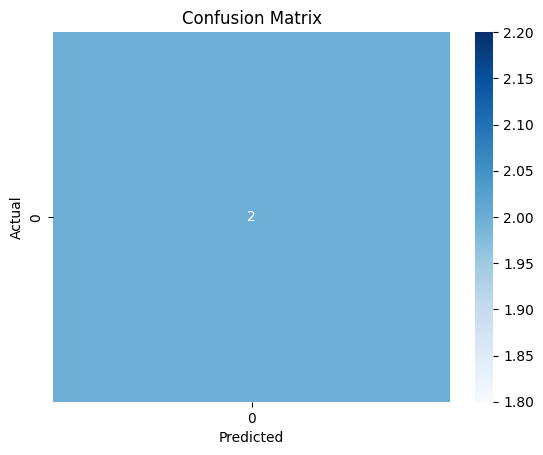

In [22]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Visualize Suspicious Routes

🟠 Orange Marker = Last known location before blackout

🔴 Red Marker = First known location after blackout

🔻 Red Line = Distance vehicle traveled while GPS was off

In [25]:
import folium
from folium.plugins import MarkerCluster

# Center of map (can be dynamic based on average)
map_center = [23.15, 79.65]
m = folium.Map(location=map_center, zoom_start=12)
marker_cluster = MarkerCluster().add_to(m)

# Plot suspicious blackout events
for _, row in feature_df[feature_df['suspicious']].iterrows():
    lat_before = df[(df['vehicle_id'] == row['vehicle_id']) & (df['timestamp'] == row['start_time'])]['latitude'].values[0]
    lon_before = df[(df['vehicle_id'] == row['vehicle_id']) & (df['timestamp'] == row['start_time'])]['longitude'].values[0]

    lat_after = df[(df['vehicle_id'] == row['vehicle_id']) & (df['timestamp'] == row['end_time'])]['latitude'].values[0]
    lon_after = df[(df['vehicle_id'] == row['vehicle_id']) & (df['timestamp'] == row['end_time'])]['longitude'].values[0]

    # Marker before blackout
    folium.Marker(
        location=[lat_before, lon_before],
        popup=f"[BEFORE] {row['vehicle_id']} at {row['start_time']}",
        icon=folium.Icon(color='orange', icon='pause')
    ).add_to(marker_cluster)

    # Marker after blackout
    folium.Marker(
        location=[lat_after, lon_after],
        popup=f"[AFTER] {row['vehicle_id']} at {row['end_time']}",
        icon=folium.Icon(color='red', icon='exclamation-sign')
    ).add_to(marker_cluster)

    # Draw a line between blackout points
    folium.PolyLine(
        locations=[[lat_before, lon_before], [lat_after, lon_after]],
        color='red',
        weight=3,
        opacity=0.7,
        tooltip=f"Blackout duration: {int(row['blackout_duration'])} sec"
    ).add_to(m)

# Show the map
m


#  To Save Model

In [24]:
import joblib
joblib.dump(rf, 'rf_model_gps.pkl')

['rf_model_gps.pkl']